# Part 3 - Geotagging of Data and Viz

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import requests
import pycountry

We import data from from our pickle object.

In [3]:
df = pd.read_pickle('data/all_data.pkl')

Function to extract musicbrainz code from artist name. We'll use the musicbrainz code later to get artists locations.

In [4]:
def get_location_data(artist):
    link='http://musicbrainz.org/ws/2/artist/'
    params={'query':'artist:'+artist,
        'fmt':'json'}
    return requests.get(link,params).json()

For geocodding our artist data, we choose only artists with more than 5 scrobble as they are more relevant.

Before, let's see how much they amount to in all the scrobbles.

In [5]:
artists_amount = df.groupby('artist')['album'].agg(['count']).reset_index()

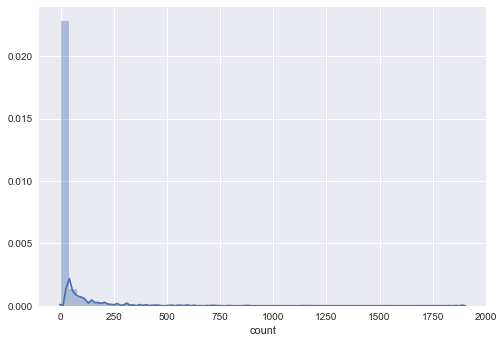

In [6]:
sns.distplot(artists_amount['count'])
plt.show()

##### The distribution shows that there's a lot of artists with less than 5 scrobbles but they don't amount to a lot of scrobbles. That's what we're going to find out below.

In [7]:
print 'Number of artists : ' + str(artists_amount.count()['artist'])
print 'Number of artists with more than 1 scrobble : ' + str(artists_amount[artists_amount['count']>1].count()['artist'])
print 'Number of artists with more than 5 scrobble : ' + str(artists_amount[artists_amount['count']>5].count()['artist'])

Number of artists : 3604
Number of artists with more than 1 scrobble : 2152
Number of artists with more than 5 scrobble : 1174


In [8]:
artists_chosen=artists_amount[artists_amount['count']>5]['artist'].tolist()
df_artists_chosen=df[df.artist.isin(artists_chosen)]

In [9]:
print 'Number of total scrobbles : ' + str(df.count()['artist'])
print 'Number total scrobbles from chosen artists : ' + str(df_artists_chosen.count()['artist'])

Number of total scrobbles : 92763
Number total scrobbles from chosen artists : 88248


Yea let's put this in a pie chart, it's much cooler.

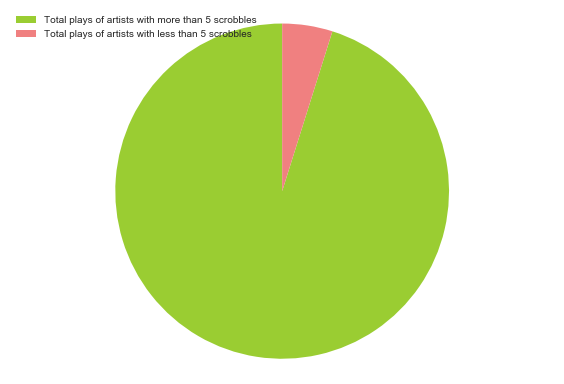

In [10]:
labels = ['Total plays of artists with more than 5 scrobbles', 'Total plays of artists with less than 5 scrobbles']
sizes = [df_artists_chosen.count()['artist'], df.count()['artist']-df_artists_chosen.count()['artist']]
colors = [ 'yellowgreen','lightcoral']
patches, texts = plt.pie(sizes, colors=colors, shadow=False, startangle=90)
plt.legend(patches, labels, loc="best")
plt.axis('equal')
plt.tight_layout()
plt.show()

We can see that they constitute only 8.5% of total scrobbles.

### Now, we're gonna try to geotag artists using MusicBrainz API.

First, we have to make sure every artist has a MBID.

In [11]:
artists_mb=df[['artist','artist_mbid']][(df.artist.isin(artists_chosen))].drop_duplicates()
artists_mb['name']= None

We create this function to compare strings in order to match with the artist. It returns a normalized string in lower letters without any special character.

In [12]:
import re
import unicodedata

def comp_st(a):
    p=re.compile(r'\([^)]*\)')
    a=re.sub(p, '',a)
    a= unicodedata.normalize('NFKD', a).encode('ascii', 'ignore')
    a=filter(str.isalnum,a)
    return a.lower()

We loop through the artists. For each one, we call the function to get the artist's location from the musicbrainz api. 

If there's a match between the artist and the first one returned by the api, it's good, if not we try with the second one and if we don't have a match match with it we stop looking for the artist.

In [14]:
artists_not_found=[]
for artist in artists_mb.values:
    try:
        data_art = get_location_data(artist[0])['artists']
        data_artist_1 = data_art[0]
        if (comp_st(data_artist_1['name'])== comp_st(artist[0])):
            artists_mb.loc[artists_mb.artist==artist[0],'artist_mbid']=data_artist_1['id']
            artists_mb.loc[artists_mb.artist==artist[0],'name']=data_artist_1['name']
        else:
            data_artist_1 = data_art[1]
            if (comp_st(data_artist_1['name'])== comp_st(artist[0])):
                artists_mb.loc[artists_mb.artist==artist[0],'artist_mbid']=data_artist_1['id']
                artists_mb.loc[artists_mb.artist==artist[0],'name']=data_artist_1['name']
            else:
                artists_not_found.append(artist[0])

    except Exception as e:
        artists_not_found.append(artist[0])
        

    time.sleep(0.6) #cannot get faster than this

In [15]:
print 'Number of artists without MBID : ' + str(artists_mb[artists_mb.artist_mbid.isnull()].count()['artist'])
print 'Number of artists without MBID : ' + str(artists_mb[artists_mb.artist_mbid.notnull()].count()['artist'])

Number of artists without MBID : 30
Number of artists without MBID : 1144


The score is better than expected.

## Now, we match MBIDs on musicbrainz to get location of artists

Now that the artists have an MBID. We use the musicbrainz artists api to get location info about each one.

In [17]:
def get_location_data_art(artist):
    link='http://musicbrainz.org/ws/2/artist/'+artist
    params={'inc':'aliases',
        'fmt':'json'}
    return requests.get(link,params).json()

In [18]:
artists_mb['area']= None
artists_mb['type']= None

In [19]:
artists_mb = artists_mb[artists_mb.artist_mbid.notnull()]

In [21]:
artist_area_not_found=[]
for artist in artists_mb.values:
    #print artist[0]
    art_loc = get_location_data_art(artist[1])
    try:
        artists_mb.loc[artists_mb.artist_mbid==artist[1],'area']=art_loc['area']['name']
        artists_mb.loc[artists_mb.artist_mbid==artist[1],'type']=art_loc['type']
    except: 
        artist_area_not_found.append(artist[0])
    time.sleep(0.6)

From what we recieved from Musicbrainz, some artists are tagged in a country and some are tagged in a city. We want to uniformize this by using the country code, we'll need to retrive the country from the cities names. 

In order to achieve this, we use the openstreetmap API. The following function gets the area name and returns the country code that we put in a new column Country.

In [80]:
def get_country(area):
    link = 'https://nominatim.openstreetmap.org/search'
    params={'q': area,
        'format':'json','addressdetails' : 1}
    return requests.get(link,params).json()[0]['address']['country_code'].upper()

In [23]:
artists_mb.is_copy=False
artists_mb['country']= None

In [24]:
artist_area_not_found=[]
for artist in artists_mb.values:
    try:
        artists_mb.loc[artists_mb.artist==artist[0],'country_name']=get_country(artist[3])
    except:
        artist_area_not_found.append(artist[0])
        #print "no area found for artist : " + artist[0]
    time.sleep(0.5)

We count the number of artists per country.

In [215]:
artists_mb_w_areas=artists_mb[artists_mb.country.notnull()].copy()
artists_mb_w_areas=artists_mb_w_areas.groupby('country')['artist'].agg([('count')]).reset_index().sort_values('count', ascending=False)

We use the library Pycountry to get the country name and the country code in ISO3 because the country code given by Openstreetmap is in ISO2.

In [228]:
artists_mb_w_areas['country_A3']=None
artists_mb_w_areas['country_name']=None

for artist in artists_mb_w_areas.values:
    country_A2=artist[0]
    country_A3=pycountry.countries.get(alpha_2=country_A2).alpha_3
    country_name=pycountry.countries.get(alpha_2=country_A2).name
    artists_mb_w_areas.loc[artists_mb_w_areas.country==country_A2,['country_A3','country_name']]=[country_A3,country_name]

Let's plot a horizontal barplot of the number of artists by country.

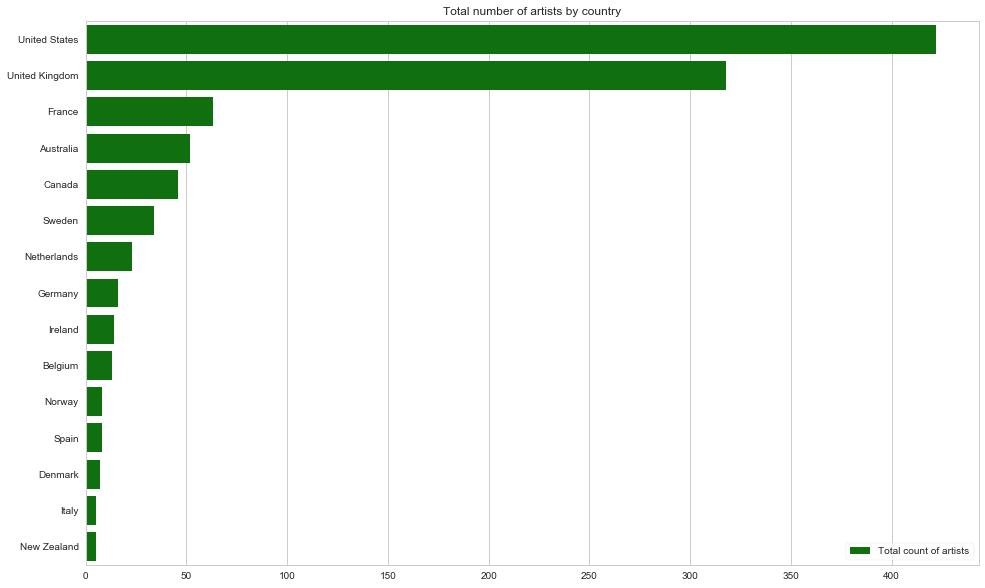

In [231]:
def plot_top(attrib, title,label):
    sns.set(style="whitegrid")
    figsize = (16, 10)
    f, ax = plt.subplots(figsize=figsize)

    group  = artists_mb_w_areas.head(15)

    sns.set_color_codes("bright")
    sns.barplot(x="count", y=attrib, data=group,
                label=label, color="green")
    
    
    # Add a legend and informative axis label
    ax.legend( ncol=2, loc="lower right", frameon=True)
    ax.set(ylabel="", xlabel="")
    ax.set_title(title)
    
    plt.show()
    
plot_top('country_name', 'Total number of artists by country','Total count of artists')

# Chloropleth map

We use geopandas to read a world map geometry file. We'll use this data to draw a chloropleth map of the number of artists per country.

In [129]:
import geopandas as gpd
import os

In [40]:
shapefile = os.path.abspath('~\\map_data\\ne_10m_admin_0_countries.shp')

In [157]:
gdf = gpd.read_file(shapefile)[['ADM0_A3','ISO_A3', 'geometry']].to_crs('+proj=robin')
gdf.sample(5)

,ADM0_A3,ISO_A3,geometry
127,BGD,BGD,"(POLYGON ((8561091.62806344 2350547.999085892,..."
230,TON,TON,(POLYGON ((-16181406.26134152 -1985807.2039262...
111,SMR,SMR,"POLYGON ((1059325.650683354 4688410.446229615,..."
69,KGZ,KGZ,"POLYGON ((6902876.921655496 4508556.187206768,..."
123,SWZ,SWZ,POLYGON ((2930501.055415542 -2776260.992362202...


In [159]:
merged = gdf.merge(artists_mb_w_areas, left_on='ADM0_A3', right_on='country_A3', how='left')
merged = merged.fillna(0)
#merged.describe()

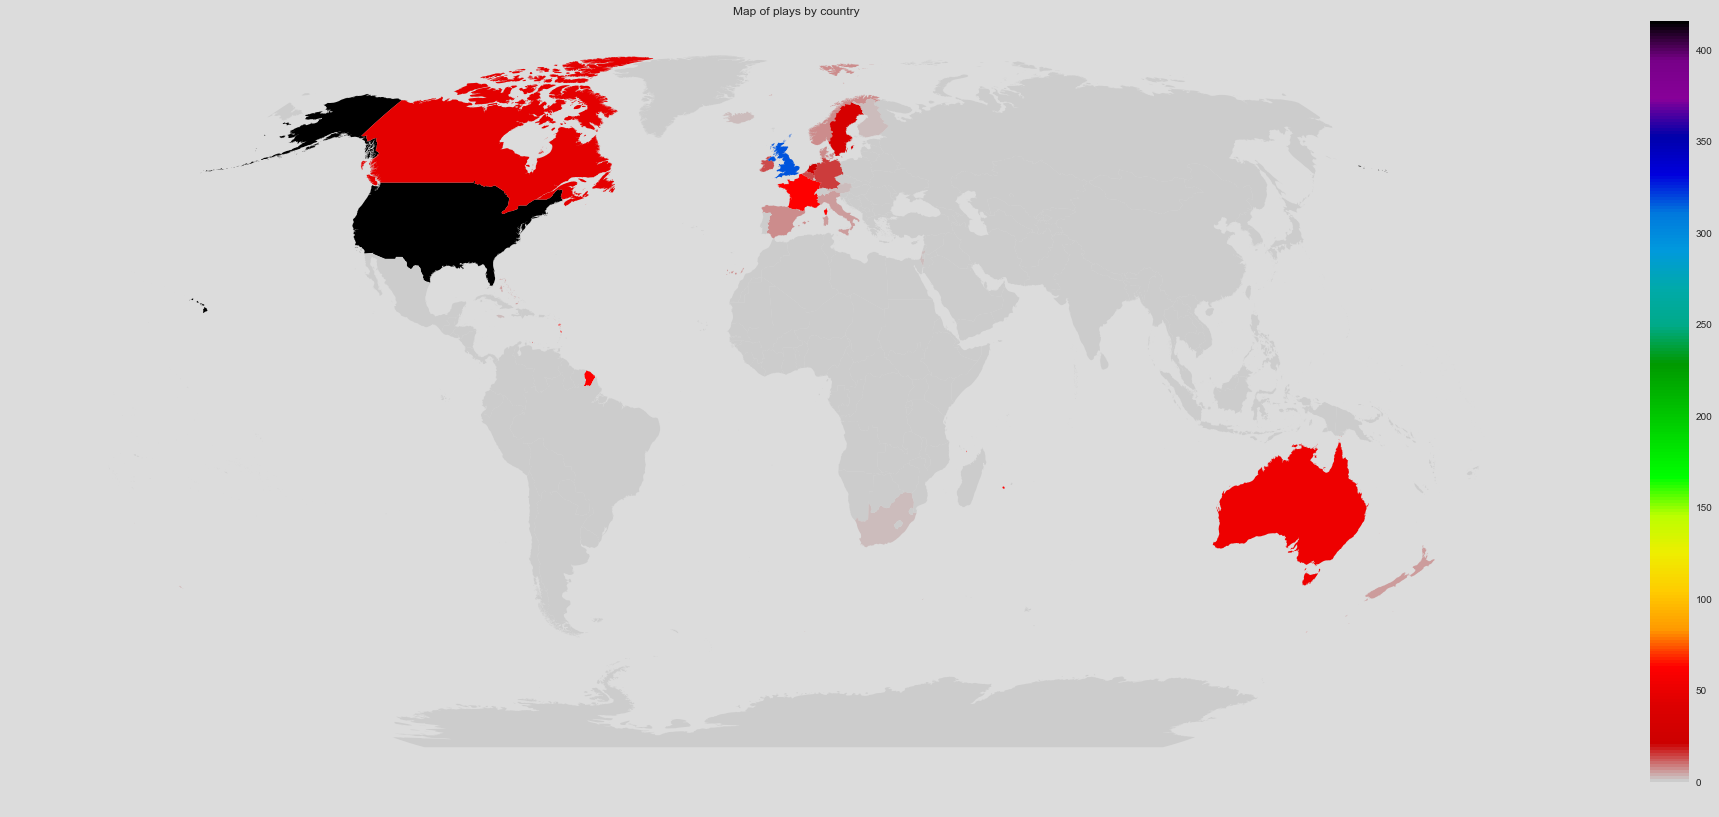

In [185]:
sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'gainsboro'})
#sns.set(style="whitegrid")
colors = 20
cmap = 'spectral_r'
figsize = (35, 14)

ax = merged.dropna().plot(column='count', cmap=cmap, figsize=figsize,  k=colors, legend=True)
plt.axis('off')
plt.title('Map of plays by country')
plt.show()